In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from tqdm import tqdm, trange
from rich import inspect
from typing import List
from torch import Tensor
from sklearn.decomposition import PCA

from vae import VAE

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

# net = VAE(10, state_dict_path="./vae.pt")

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.2864), (0.3203)
    ),
])


BATCH_SIZE = 64

train_loader = DataLoader(
    torchvision.datasets.FashionMNIST(
        "./data/", train=True, download=True, transform=transform
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = DataLoader(
    torchvision.datasets.FashionMNIST(
        "./data/", train=False, download=True, transform=transform
    ),
    batch_size=BATCH_SIZE,
)

n_classes = len(set([label for _, batch_label in test_loader for label in batch_label]))

# Variational Autoencoder

In [22]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int, hidden_dims: List[int]) -> None:
        super(Encoder, self).__init__()
            
        layers = [] 
        self.input = nn.Sequential(
            nn.Conv2d(1, hidden_dims[0], kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(hidden_dims[0]),
            nn.ReLU(),
        )
        
        # Iterate over hidden layers two at a time 
        # i.e. hidden_dims = [1, 2, 4, 8, 16, ...]
        # (1, 2)
        # (2, 4)
        # (4, 8)
        # ...
        for h1, h2 in zip(hidden_dims, hidden_dims[1:]): 
            layers.append(nn.Sequential(
                nn.Conv2d(h1, h2, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(h2),
                nn.ReLU()
            ))

        self.encoder = nn.Sequential(*layers)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)
        self.flatten = nn.Flatten()


    def forward(self, x: Tensor):
        x = self.input(x)
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim: int, hidden_dims: List[int] ) -> None:
        super(Decoder, self).__init__()
        self.input = nn.Linear(latent_dim, hidden_dims[0] * 4 * 4)
        self.hidden_dims = hidden_dims
        layers = []
        
        for h1, h2 in zip(hidden_dims, hidden_dims[1:]):
            layers.append(nn.Sequential(
                nn.ConvTranspose2d(h1, h2, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(h2),
                nn.ReLU()
            ))

        self.decoder = nn.Sequential(*layers)
        self.output = nn.Sequential(
            # Upsample from [C x 16 x 16] to [C x 28 x 28]
            # Where C is the number of channels in the final layer
            nn.ConvTranspose2d(
                in_channels=hidden_dims[-1],
                out_channels=hidden_dims[-1],
                kernel_size=3,
                stride=2,
                padding=3,
                output_padding=1
            ),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.ReLU(),
            # Reduce channels from 32 to 1
            nn.Conv2d(
                in_channels=hidden_dims[-1],
                out_channels=1, 
                kernel_size=1
            ),
            nn.Tanh()
        )
    
    def forward(self, z: Tensor): 
        z = self.input(z)
        z = z.view(-1, self.hidden_dims[0], 4, 4)
        z = self.decoder(z)
        z = self.output(z)
        return z

class VAE(nn.Module):
    def __init__(self, latent_dims: int, hidden_dimensions: List[int] = [32, 64, 128]) -> None:
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dims, hidden_dimensions)
        self.decoder = Decoder(latent_dims, hidden_dimensions[::-1])
        
    @staticmethod
    def reparameterize(mu: Tensor, logvar: Tensor) -> Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    @staticmethod
    def loss_function(reconstruction: Tensor, input: Tensor, mu: Tensor, log_var: Tensor, kld_weight = 0.00025):
        recons_loss = F.mse_loss(input=reconstruction, target=input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        loss = recons_loss + kld_weight * kld_loss

        return {'loss': loss, 'reconstruction_loss':recons_loss.detach(), 'kld_loss': -kld_loss.detach()}

    def forward(self, input: Tensor):
        mu, log_var = self.encoder(input)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), input, mu, log_var


In [23]:
EPOCHS = 20
LATENT_DIMS = 10
net = VAE(LATENT_DIMS).to(device)
optim = torch.optim.AdamW(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
lrs = [] 

def test(model, data, pbar = True):
    model.eval()
    test_loss = []
    f = tqdm if pbar else lambda x, **kwargs: x
    for img, label in f(data, desc="Testing"):
        img = img.to(device)
        with torch.no_grad():
            output = model(img)
        loss = VAE.loss_function(*output)
        test_loss.append(loss)

    loss_total = [loss["loss"] for loss in test_loss]
    recons_loss_total = [loss["reconstruction_loss"] for loss in test_loss]
    kld_loss_total = [loss["kld_loss"] for loss in test_loss]

    model.train()

    return {
        "loss": sum(loss_total) / len(loss_total),
        "recons_loss": sum(recons_loss_total) / len(recons_loss_total),
        "kld_loss": sum(kld_loss_total) / len(kld_loss_total),
    }

current_test_loss = test(net, test_loader, pbar=False)
print("PRETRAIN TEST RESULTS")
print(
    f"Total Loss:\t\t{current_test_loss['loss']}\nReconstruction Loss:\t{current_test_loss['recons_loss']}\nKLD Loss:\t\t{current_test_loss['kld_loss']}"
)
test_loss = []
train_loss = []
for i in range(EPOCHS):
    for img, label in tqdm(train_loader, desc=f"Epoch {i + 1}/{EPOCHS}"):
        img = img.to(device)

        optim.zero_grad()

        reconstructed_image, original, mu, log_var = net(img)
        loss = net.loss_function(reconstructed_image, original, mu, log_var, kld_weight=0.001)
        train_loss.append(loss)
        loss["loss"].backward()
        optim.step()
    current_test_loss = test(net, test_loader)
    scheduler.step(current_test_loss['loss'])
    print(
        f"Total Loss:\t\t{current_test_loss['loss']}\nReconstruction Loss:\t{current_test_loss['recons_loss']}\nKLD Loss:\t\t{current_test_loss['kld_loss']}\nLR:\t\t\t{scheduler.get_last_lr()[0]}"
    )
    test_loss.append(current_test_loss)
    lrs.append(scheduler.get_last_lr())
torch.save(net.state_dict(), "vae.pt")

PRETRAIN TEST RESULTS
Total Loss:		1.2104822397232056
Reconstruction Loss:	1.2104787826538086
KLD Loss:		-0.012295999564230442


Testing: 100%|██████████| 157/157 [00:00<00:00, 221.37it/s]


Total Loss:		0.25652334094047546
Reconstruction Loss:	0.2506338059902191
KLD Loss:		-23.558164596557617
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 159.62it/s]


Total Loss:		0.24597026407718658
Reconstruction Loss:	0.23991809785366058
KLD Loss:		-24.2086238861084
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 182.44it/s]


Total Loss:		0.23674224317073822
Reconstruction Loss:	0.230988547205925
KLD Loss:		-23.015066146850586
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 224.43it/s]


Total Loss:		0.23704752326011658
Reconstruction Loss:	0.23106874525547028
KLD Loss:		-23.914743423461914
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 203.86it/s]


Total Loss:		0.23473677039146423
Reconstruction Loss:	0.2289475053548813
KLD Loss:		-23.156797409057617
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 206.99it/s]


Total Loss:		0.23417697846889496
Reconstruction Loss:	0.22845245897769928
KLD Loss:		-22.8976993560791
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 209.83it/s]


Total Loss:		0.23399357497692108
Reconstruction Loss:	0.22834372520446777
KLD Loss:		-22.599689483642578
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 224.71it/s]


Total Loss:		0.23067787289619446
Reconstruction Loss:	0.22481895983219147
KLD Loss:		-23.43547248840332
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 200.69it/s]


Total Loss:		0.2325749695301056
Reconstruction Loss:	0.22713159024715424
KLD Loss:		-21.773771286010742
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 217.99it/s]


Total Loss:		0.23202992975711823
Reconstruction Loss:	0.22642186284065247
KLD Loss:		-22.432418823242188
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 221.06it/s]


Total Loss:		0.22978317737579346
Reconstruction Loss:	0.22403739392757416
KLD Loss:		-22.983367919921875
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 198.44it/s]


Total Loss:		0.22912925481796265
Reconstruction Loss:	0.22327928245067596
KLD Loss:		-23.399940490722656
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 209.40it/s]


Total Loss:		0.2288101613521576
Reconstruction Loss:	0.22310402989387512
KLD Loss:		-22.824560165405273
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 198.49it/s]


Total Loss:		0.2289687991142273
Reconstruction Loss:	0.22348099946975708
KLD Loss:		-21.951250076293945
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 217.06it/s]


Total Loss:		0.22662468254566193
Reconstruction Loss:	0.22076596319675446
KLD Loss:		-23.435009002685547
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 213.41it/s]


Total Loss:		0.23058083653450012
Reconstruction Loss:	0.2249162793159485
KLD Loss:		-22.658382415771484
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 215.26it/s]


Total Loss:		0.23065131902694702
Reconstruction Loss:	0.22494857013225555
KLD Loss:		-22.811311721801758
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 182.64it/s]


Total Loss:		0.22729738056659698
Reconstruction Loss:	0.22172045707702637
KLD Loss:		-22.307355880737305
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 166.47it/s]


Total Loss:		0.22899827361106873
Reconstruction Loss:	0.22331126034259796
KLD Loss:		-22.74810028076172
LR:			0.01


Testing: 100%|██████████| 157/157 [00:00<00:00, 195.47it/s]

Total Loss:		0.22647376358509064
Reconstruction Loss:	0.22094053030014038
KLD Loss:		-22.133089065551758
LR:			0.01


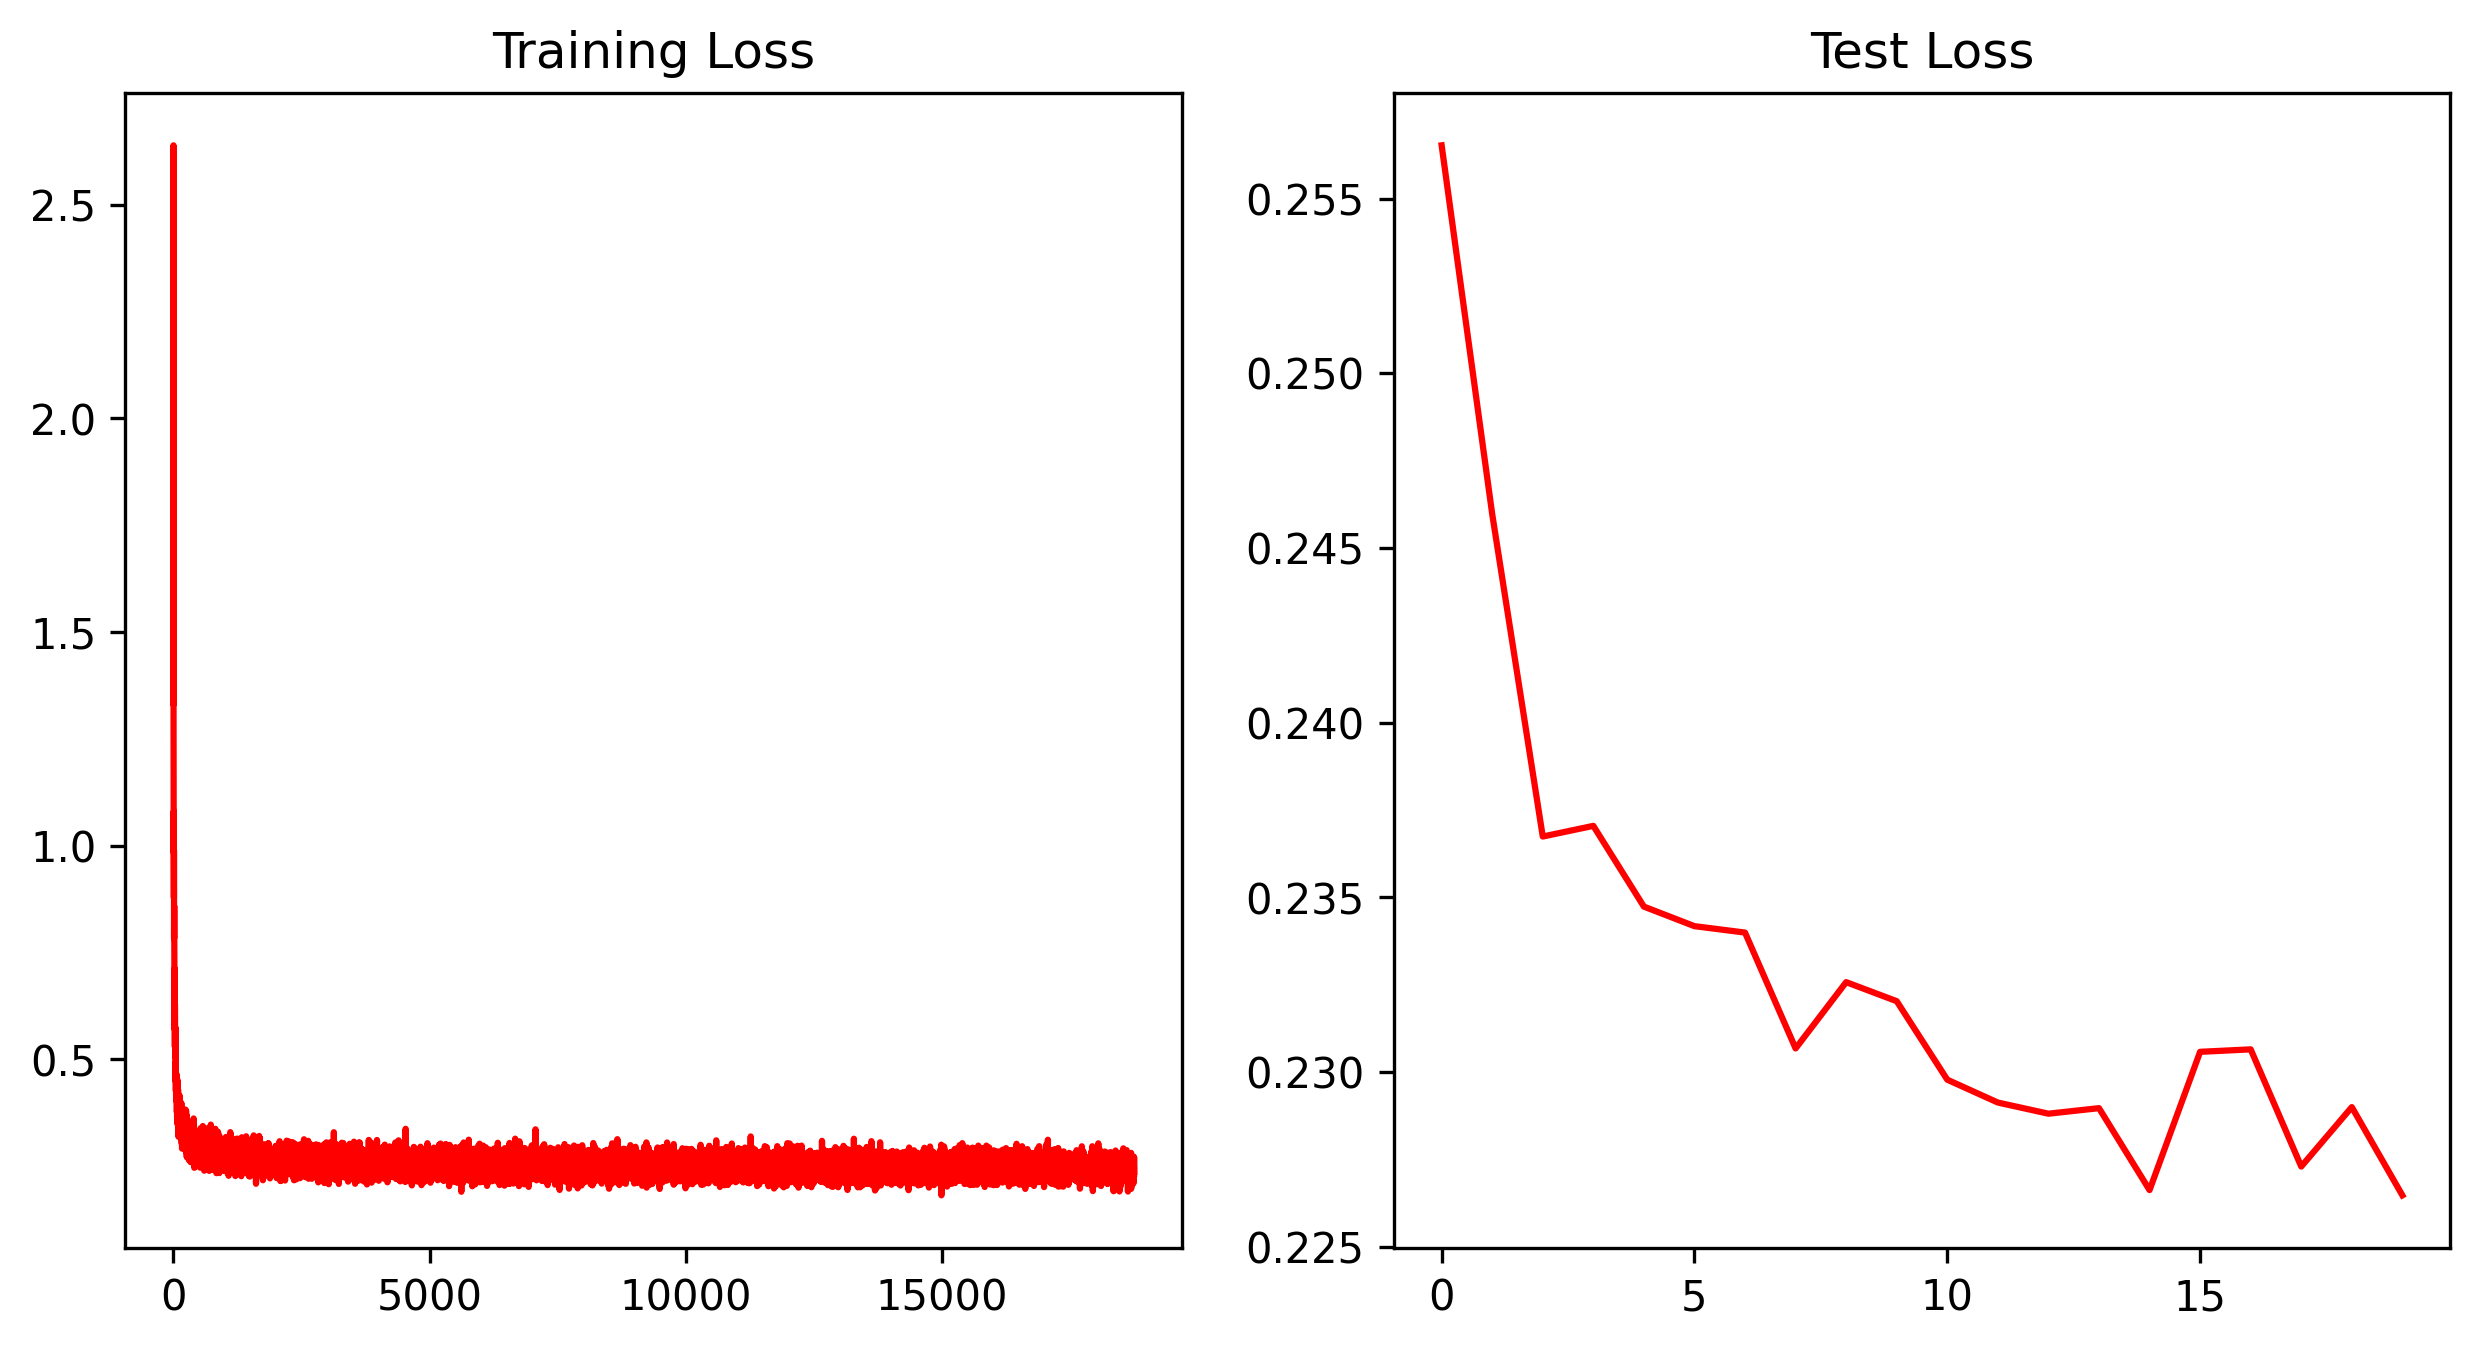

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax[0].title.set_text("Training Loss")
ax[0].plot([loss["loss"].cpu().detach() for loss in train_loss], label="Loss", c="red")
ax[1].title.set_text("Test Loss")
ax[1].plot([loss["loss"].cpu().detach() for loss in test_loss], c="red", label="Loss")
plt.show()

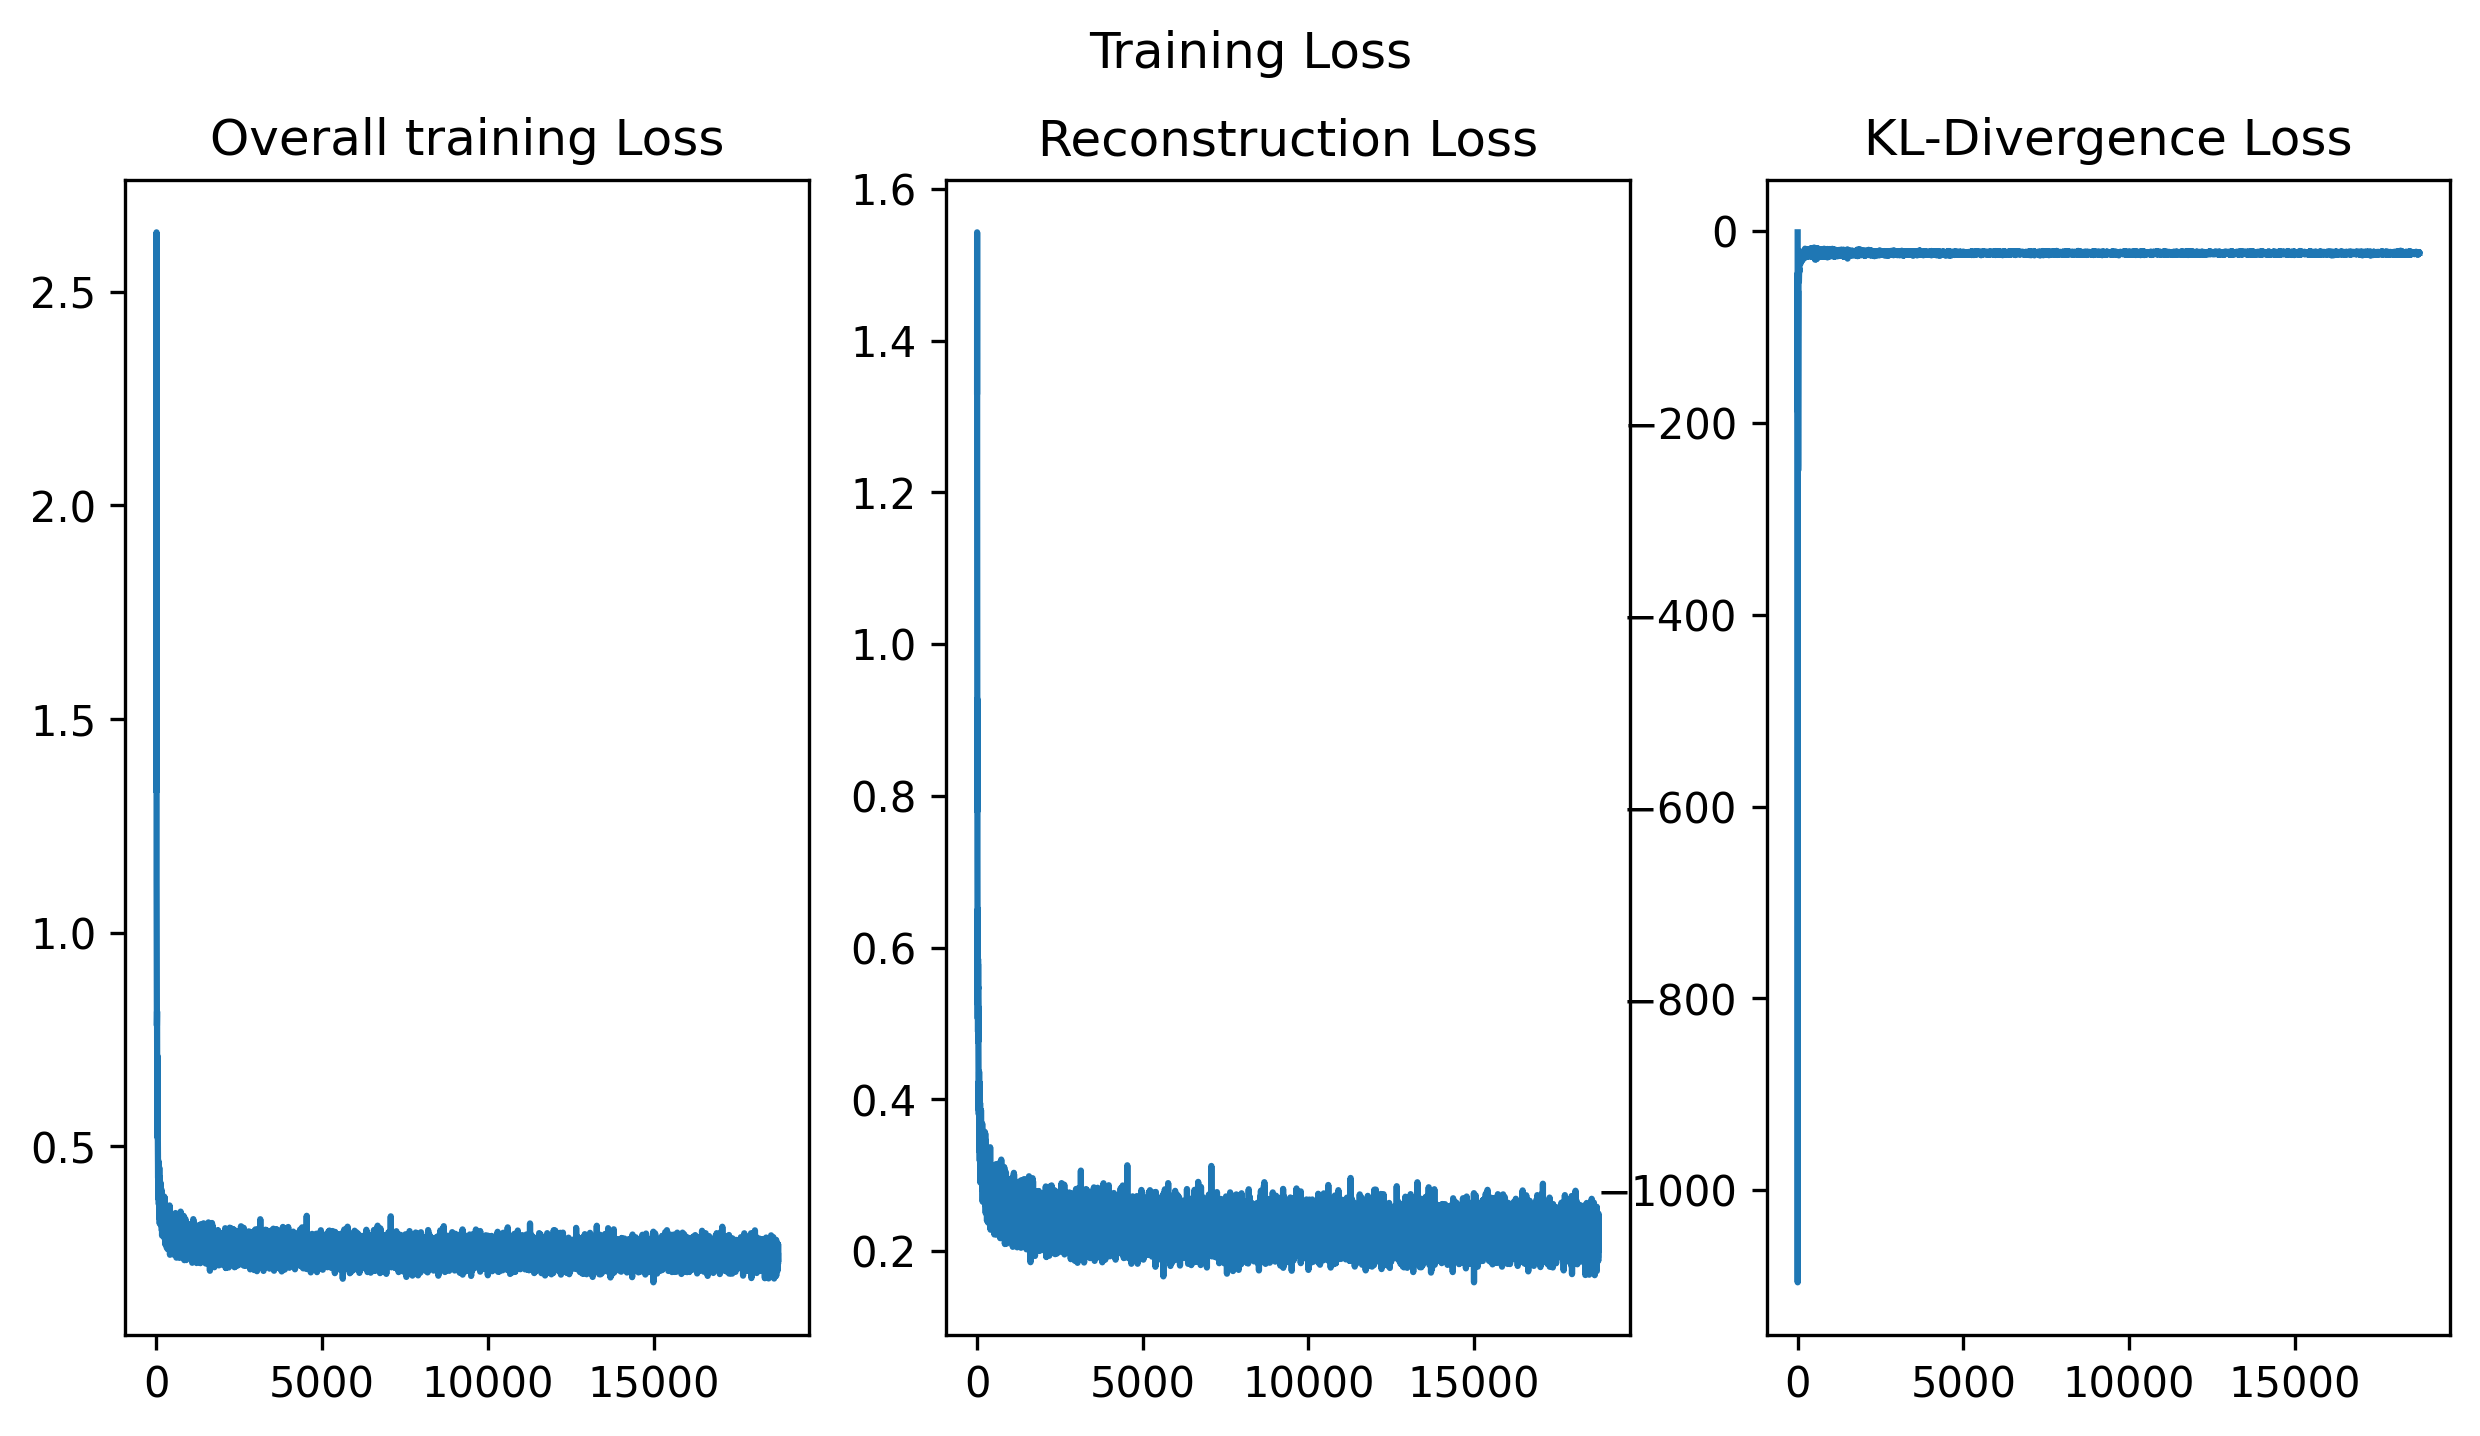

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), dpi=300)
fig.suptitle("Training Loss")
axs[0].title.set_text("Overall training Loss")
axs[0].plot([loss["loss"].cpu().detach() for loss in train_loss])
axs[1].title.set_text("Reconstruction Loss")
axs[1].plot([loss["reconstruction_loss"].cpu().detach() for loss in train_loss])
axs[2].title.set_text("KL-Divergence Loss")
axs[2].plot([loss["kld_loss"].cpu().detach() for loss in train_loss])
plt.show()

In [26]:
encodings = [] 
for img, label in tqdm(test_loader, desc="Generating encodings"): 
    img = img.to(device)
    mu, logvar = net.encoder(img)
    encoded = net.reparameterize(mu, logvar).detach().cpu().numpy()
    encodings.extend(encoded)
encodings = np.array(encodings)

Generating encodings: 100%|██████████| 157/157 [00:00<00:00, 178.84it/s]


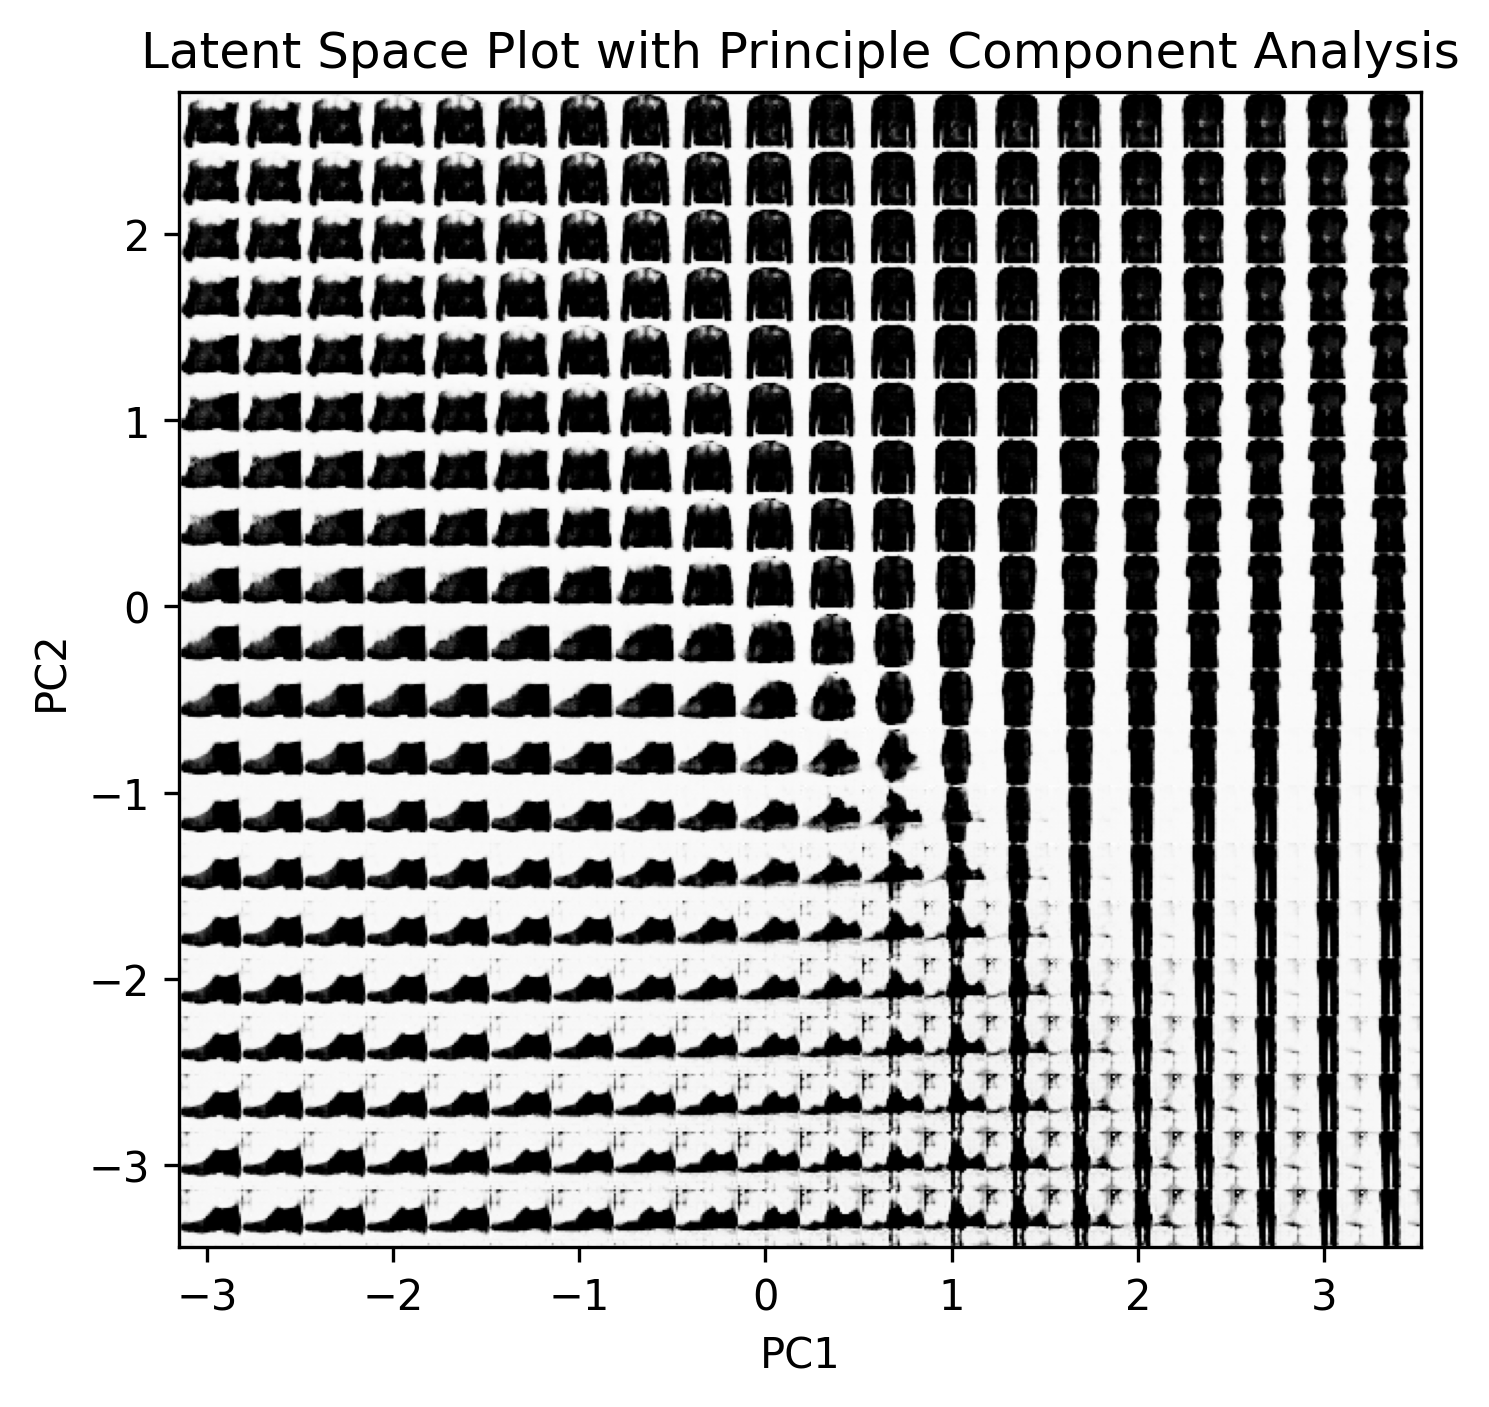

In [28]:
N = 20

def reconstruct_image(input):
    encoded = torch.tensor(input, dtype=torch.float32).to(device)
    recons = net.decoder(encoded).detach().cpu().numpy()[0]
    return recons.reshape(28, 28)

pca = PCA(n_components=2)
pca.fit(encodings)
X = pca.fit_transform(encodings)
W = pca.components_.T 
mu = pca.mean_
image = np.zeros((28 * N, 28 * N))
pc1 = X[:, 0]
pc2 = X[:, 1]

xs = np.linspace(np.floor(np.min(pc1)), np.ceil(np.max(pc1)), N)
ys = np.linspace(np.floor(np.min(pc2)), np.ceil(np.max(pc2)), N)

for i, x in enumerate(xs): 
    for j, y in enumerate(ys): 

        img = reconstruct_image(np.dot(W, np.array([x, y])) + mu)
        image[(N-1-i)*28:(N-1-i+1)*28, j*28:(j+1)*28] = img
plt.subplots(figsize=(10, 5), dpi=300)
plt.title("Latent Space Plot with Principle Component Analysis")
plt.imshow(image, cmap="Grays", extent=[np.min(pc1), np.max(pc1), np.min(pc2), np.max(pc2)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

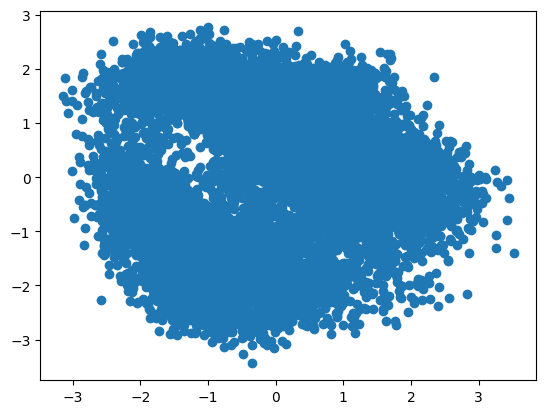

In [30]:
plt.scatter(pc1, pc2)
plt.show()